Importamos las librerías necesarias para el notebook

In [ ]:
import os
    
# Main libraries that we will use in this kernel
import datetime
import numpy as np
import pandas as pd

# # garbage collector: free some memory is needed
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

import time

from string import punctuation
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

# Pickle from EDA

Nos conectamos a nuestro Drive y cargamos el pickle creado durante la fase de EDA

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.path.abspath(os.getcwd())

'/content'

In [ ]:
ruta_marc = '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/df_pickle_v2'

In [ ]:
import pickle

with open(ruta_marc, 'rb') as handle:
    df_ = pickle.load(handle)

- se ganan 10€ por cada cuenta vendida ['em_account_pp', 'payroll_account', 'emc_account', 'em_account_p', 'em_acount']
- 40€ por los productos de ahorro e inversión (planes, fondos, etc.) ['short_term_deposit', 'funds', 'securities', 'long_term_deposit', 'payroll', 'pension_plan']
- 60€ por los de financiación (préstamos y tarjetas) ['loans', 'mortgage', 'credit_card', 'debit_card']

In [ ]:
# Vistazo general del pickle cargado
df_

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,28.0,H,59,N,NaN,0,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,59,N,NaN,0,2018,8,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962973,16063,2018-11-28,2018-11-19,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2018,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,62,N,NaN,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679916,1553685,2019-05-28,2019-05-31,NaN,0.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,13.0,V,52,N,NaN,0,2019,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5679915,1553686,2019-05-28,2019-05-31,NaN,0.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,41.0,H,30,N,NaN,0,2019,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5679914,1553687,2019-05-28,2019-05-31,NaN,0.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,21,N,NaN,0,2019,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5679913,1553688,2019-05-28,2019-05-31,NaN,0.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,39.0,H,43,N,NaN,0,2019,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Comprobamos que el pickle cargado ya contiene los cálculos realizados en el EDA donde se creaban las columnas "_diff" entre periodos por la combinación cliente,producto para identificar altas (1) y bajas (-1). En las columnas de "_price" se muestra el precio pagado por el cliente por ese producto si tiene una alta.

In [ ]:
df_[df_.pk_cid == 17457][['long_term_deposit','debit_card', 'credit_card', 'em_acount', 'long_term_deposit_diff','debit_card_diff','credit_card_diff', 'em_acount_diff','long_term_deposit_price','debit_card_price', 'credit_card_price', 'em_acount_price']]

,long_term_deposit,debit_card,credit_card,em_acount,long_term_deposit_diff,debit_card_diff,credit_card_diff,em_acount_diff,long_term_deposit_price,debit_card_price,credit_card_price,em_acount_price
237929,1,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241166,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
586811,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
728998,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1222865,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1474919,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
1479564,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2168118,1,0,0,1,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2171487,1,1,0,1,0.0,1.0,0.0,0.0,NaN,60.0,NaN,NaN
2943632,0,0,0,1,-1.0,-1.0,0.0,0.0,NaN,NaN,NaN,NaN


# Preprocessing df

La información es correcta, por lo que eliminamos las columnas originales de productos y las de "_previous_month" para reducir el df

In [ ]:
# del EDA sabemos que em_account_p y em_account_pp no sufren altas ni bajas por lo que no las tenemos en cuenta y tampoco aparecen en el pickle cargado
prod_cols = ["short_term_deposit", "loans", "mortgage", "funds", "securities","long_term_deposit", "credit_card", "payroll_account", "emc_account", "debit_card", "em_acount", "pension_plan"]  #payroll no la borramos
col_prev_month = []

for col in prod_cols:
  col_prev_month.append(col+'_previous_month')

# for cols_df in df.columns:
#   for cols_to_int in prod_cols:
#     if cols_to_int in cols_df:
#       df[cols_df].fillna(0, inplace=True)
#       df[cols_df] = df[cols_df].astype(int)    #con integer da error si hay NaNs

In [ ]:
df = df_.copy(deep=True)

In [ ]:
df.drop(prod_cols + col_prev_month, axis=1, inplace=True)

In [ ]:
df.head().T

,1479563,2168122,2962973,3628236,4028169
pk_cid,15891,15891,16063,16063,16063
pk_partition,2018-07-28 00:00:00,2018-08-28 00:00:00,2018-11-28 00:00:00,2018-12-28 00:00:00,2019-01-28 00:00:00
entry_date,2018-07-28,2018-07-28,2018-11-19,2018-11-19,2018-11-19
entry_channel,KAT,KAT,KAT,KAT,KAT
active_customer,1.0,0.0,1.0,1.0,1.0
segment,NaN,02 - PARTICULARES,NaN,02 - PARTICULARES,02 - PARTICULARES
em_account_pp,0,0,0,0,0
payroll,0.0,0.0,0.0,0.0,0.0
em_account_p,0,0,0,0,0
country_id,ES,ES,ES,ES,ES


# RFM Model

Aquí ya tenemos las altas y bajas de cada cliente por cada producto y el precio pagado en cada alta según la tipología del producto.

Al trabajar con productos financieros y clientes que los adquieren, nos basaremos en el modelo **RFM (Recency, Frequency, Monetary Value)** para la segmentación de clientes. 
- Qué reciente es la última compra.
- Con qué frecuencia adquieren uno/varios productos de nuestra compañía, frecuencia de actividad.
- El valor monetario gastado en nuestra compañía a través de estos productos.

In [ ]:
df.columns[:-25]

Index(['pk_cid', 'pk_partition', 'entry_date', 'entry_channel',
       'active_customer', 'segment', 'em_account_pp', 'payroll',
       'em_account_p', 'country_id', 'region_code', 'gender', 'age',
       'deceased', 'salary', 'deceased_num', 'year_partition',
       'month_partition', 'em_account_p_previous_month',
       'em_account_pp_previous_month'],
      dtype='object')

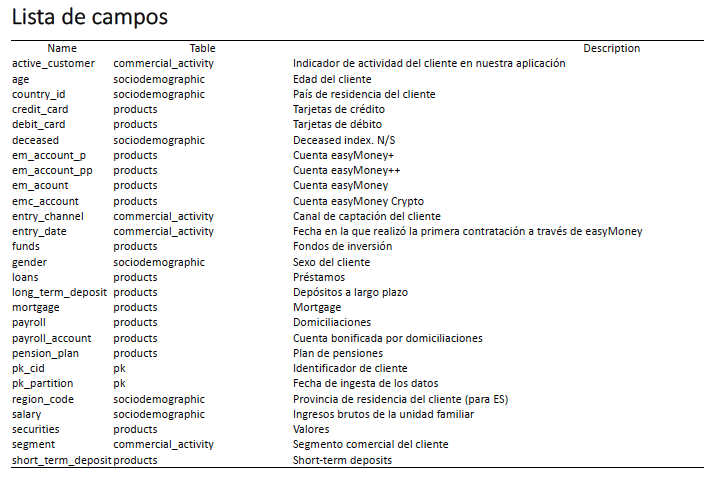

Las columnas que analizaremos inicialmente para la clusterización de clientes y ver si son interesantes para nuestro modelo son:
- **entry_date**: fecha 1a contratación con easymoney. Se utiliza l ainformación a partir de nuevas columnas creadas.
- **active_customer**: indicador actividad en aplicación. Frequency.
- **payroll**: Al ser 1,0 según si el cliente tiene domicialda su nómina con la compañía podría entrar en Monetary value.
- **altas y bajas de productos**: para calcular frecuencia de contratación y Recency.
- **price**: para tener Monetary value de los productos contratados por cada cliente, su gasto monetario en easymoney.
- **edad**: se añade como características extra de los clientes.

Se dejan fuera:
- **entry channel**: se deja fuera por no aportar a RFM.
- **segment**: una segmentación previa de la empresa. No parece útil ya que hay muchos nulos, muy pocas categorías y no tiene sentido inputar una categorización previa de la que desconocemos el proceo de obtención.
- **country_id** y **region_code**: podría ser interesante, pero al enfocar después la clusterización en la recomendación de productos por RFM y el envío de los 10k mails, no tiene sentido discriminar por zona ya que no trataremos datos geográficos como la localización de cajeros o sucursales.
- **salary**: dato dado de palabra por el cliente en el momento de la captación, no es fiable
- **gender**: se deja fuera para evitar sesgo

- **deceased**: No aporta saber si el cliente ha fallecido para nuestro modelo.



In [ ]:
cols_to_drop = ['entry_channel', 'segment', 'year_partition', 'month_partition', 'country_id', 'region_code', 'gender', 'deceased', 'salary', 'deceased_num']   #'age' para estudiarla

In [ ]:
df.drop(cols_to_drop, axis=1, inplace=True)

In [ ]:
df.head()

,pk_cid,pk_partition,entry_date,active_customer,em_account_pp,payroll,em_account_p,age,em_account_p_previous_month,em_account_pp_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,1.0,0,0.0,0,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,0.0,0,0.0,0,59,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962973,16063,2018-11-28,2018-11-19,1.0,0,0.0,0,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Features

In [ ]:
#para guardar las variables finales, sin estar divididas en partitions
df_final = pd.DataFrame()

### ACTIVE_CUSTOMER


In [ ]:
df[df.pk_cid == 16063][['pk_cid', 'pk_partition', 'active_customer']]

,pk_cid,pk_partition,active_customer
2962973,16063,2018-11-28,1.0
3628236,16063,2018-12-28,1.0
4028169,16063,2019-01-28,1.0
4480637,16063,2019-02-28,1.0
4876040,16063,2019-03-28,0.0
5134317,16063,2019-04-28,1.0
5523397,16063,2019-05-28,0.0


In [ ]:
df.groupby('pk_cid')['active_customer'].mean()

pk_cid
15891      0.500000
16063      0.714286
16203      0.833333
16502      0.888889
17457      1.000000
             ...   
1553685    0.000000
1553686    0.000000
1553687    0.000000
1553688    0.000000
1553689    0.000000
Name: active_customer, Length: 456373, dtype: float64

Podemos observar que la variable es un booleano de si el cliente ha estado activo un mes (pk_partition) o no. Con esto, calcularemos la media de actividad del cliente en nuestra actividad en todos los periodos y guarderemos los resultados en el df_final.

In [ ]:
df_final['active_mean'] = df.groupby('pk_cid')['active_customer'].mean()

In [ ]:
df_final[df_final.index ==  16063]

,active_mean
pk_cid,
16063,0.714286


In [ ]:
df_final.isnull().sum()

active_mean    0
dtype: int64

In [ ]:
df_final.shape

(456373, 1)

### ENTRY_DATE

In [ ]:
df[['entry_date']].isnull().sum()

entry_date    0
dtype: int64

In [ ]:
#hay fechas como el 2015-02-29 que no existen (visto en el EDA). Cogeremos el año y mes de entrada
df_final['entry_date'] = df['entry_date'].apply( lambda x: str(x)[:7])

In [ ]:
df_final.isnull().sum()

active_mean    0
entry_date     0
dtype: int64

In [ ]:
# comprobación para un cliente en particular
df[df['pk_cid'] == 16063]

,pk_cid,pk_partition,entry_date,active_customer,em_account_pp,payroll,em_account_p,age,em_account_p_previous_month,em_account_pp_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
2962973,16063,2018-11-28,2018-11-19,1.0,0,0.0,0,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480637,16063,2019-02-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4876040,16063,2019-03-28,2018-11-19,0.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5134317,16063,2019-04-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5523397,16063,2019-05-28,2018-11-19,0.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_final[df_final.index == 16063]

,active_mean,entry_date
pk_cid,,
16063,0.714286,2015-09


In [ ]:
df_final.shape

(456373, 2)

### PAYROLL

Al igual que la actividad del cliente de donde hemos sacado la media, hacemos lo mismo para payroll.

In [ ]:
df[df['payroll'] ==1]['pk_cid']

1479557      17970
237903       31624
241190       31624
483768       31624
729027       31624
            ...   
5680611    1551597
5680241    1551712
5680434    1551832
5680940    1552055
5680791    1552364
Name: pk_cid, Length: 205787, dtype: int64

In [ ]:
# Observamos que hay clientes que tienen la nómina domiciliada todos los meses, otros que nunca y otros que van cambiando. Puede servir para evaluar la retención del cliente y compromiso, dentro de frecuencia.
test = pd.DataFrame(df.groupby('pk_cid')['payroll'].mean())
test[test['payroll'] > 0]

,payroll
pk_cid,
17970,0.058824
31624,1.000000
32376,1.000000
33205,0.875000
35849,0.235294
...,...
1551597,1.000000
1551712,1.000000
1551832,1.000000


In [ ]:
df['payroll'].value_counts()

0.0    5757076
1.0     205787
Name: payroll, dtype: int64

In [ ]:
df_final['payroll'] = df.groupby('pk_cid')['payroll'].mean()

In [ ]:
df_final[df_final['payroll'] == 0 ]

,active_mean,entry_date,payroll
pk_cid,,,
15891,0.500000,2015-09,0.0
16063,0.714286,2015-09,0.0
16203,0.833333,2015-09,0.0
16502,0.888889,2015-09,0.0
17457,1.000000,2015-09,0.0
...,...,...,...
1553685,0.000000,2016-07,0.0
1553686,0.000000,2016-07,0.0
1553687,0.000000,2016-07,0.0


In [ ]:
df_final[df_final.index == 33205]

,active_mean,entry_date,payroll
pk_cid,,,
33205,1.0,2015-08,0.875


In [ ]:
df_final.shape

(456373, 3)

In [ ]:
df_final.isnull().sum()

active_mean    0
entry_date     0
payroll        0
dtype: int64

### EDAD?

Cogemos el máximo ya que hay clientes que son un año más grandes entre su primer y último pk_partition y la edad varía.

In [ ]:
df_final['age'] = df.groupby('pk_cid')['age'].max()

In [ ]:
#hacer bins mejor?

### ALTAS BAJAS y REVENUE

In [ ]:
prod_cols

['short_term_deposit',
 'loans',
 'mortgage',
 'funds',
 'securities',
 'long_term_deposit',
 'credit_card',
 'payroll_account',
 'emc_account',
 'debit_card',
 'em_acount',
 'pension_plan']

Generamos un df de test para probar los cálculos. Queremos encontrar el total de altas, el total de bajas y el total de revenue por cliente en todo el periodo.

#### **ALTAS**

In [ ]:
df_test = df[df.pk_cid == 17457][['pk_cid', 'debit_card_diff']]

df_test

,pk_cid,debit_card_diff
237929,17457,NaN
241166,17457,0.0
586811,17457,0.0
728998,17457,0.0
1222865,17457,0.0
1474919,17457,0.0
1479564,17457,0.0
2168118,17457,0.0
2171487,17457,1.0
2943632,17457,-1.0


In [ ]:
#altas de un cliente específico para un producto específico, en todo el rango de tiempo de estudio. Con los datos de df_test, dentro del df entero deberían ser 5 altas.
sum((df[ (df['debit_card_diff'] == 1) & (df['pk_cid'] == 17457)])['debit_card_diff'])

5.0

In [ ]:
# lo pasamos a función
def calc_altas(data):
    data.columns=['pk_cid','diff']

    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == -1, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == 1, 1, data['diff'] )

    return data.groupby('pk_cid')['diff'].sum()

In [ ]:
# con la nueva función, con el df_test funciona correctamente
calc_altas(df_test)

pk_cid
17457    5.0
Name: diff, dtype: float64

#### **BAJAS**

In [ ]:
#altas de un cliente específico para un producto específico, en todo el rango de tiempo de estudio. Con los datos de df_test, dentro del df entero deberían ser 4 (en este caso -4 pq sumamos -1s)
sum((df[ (df['debit_card_diff'] == -1) & (df['pk_cid'] == 17457)])['debit_card_diff'])

-4.0

In [ ]:
def calc_bajas(data):
    data.columns=['pk_cid','diff']

    data['diff'].fillna(0,inplace=True)
    data['diff'] = np.where( data['diff'] == 1, 0, data['diff'] )
    data['diff'] = np.where( data['diff'] == -1, 1, data['diff'] )

    return data.groupby('pk_cid')['diff'].sum()

In [ ]:
df_test_2 = df[df.pk_cid == 17457][['pk_cid', 'debit_card_diff']]

calc_bajas(df_test_2)

pk_cid
17457    4.0
Name: diff, dtype: float64

#### **REVENUE**

In [ ]:
df_test_3 = df[df.pk_cid == 17457][['pk_cid', 'debit_card_price']]
df_test_3

,pk_cid,debit_card_price
237929,17457,NaN
241166,17457,NaN
586811,17457,NaN
728998,17457,NaN
1222865,17457,NaN
1474919,17457,NaN
1479564,17457,NaN
2168118,17457,NaN
2171487,17457,60.0
2943632,17457,NaN


In [ ]:
def calc_revenue(data):
    data.columns=['pk_cid','price']

    return data.groupby('pk_cid')['price'].sum()

In [ ]:
calc_revenue(df_test_3)

pk_cid
17457    300.0
Name: price, dtype: float64

#### Para todo el **DF**

Pasamos las 3 funciones creadas y testeadas para que apliquen a todo el df.

In [ ]:
df_sorted = df.sort_values(['pk_cid', 'pk_partition'], ascending=True)
df_sorted.head(5)

,pk_cid,pk_partition,entry_date,active_customer,em_account_pp,payroll,em_account_p,age,em_account_p_previous_month,em_account_pp_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,1.0,0,0.0,0,59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,0.0,0,0.0,0,59,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962973,16063,2018-11-28,2018-11-19,1.0,0,0.0,0,62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628236,16063,2018-12-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4028169,16063,2019-01-28,2018-11-19,1.0,0,0.0,0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
for prod in prod_cols:
  if prod not in "em_account_pp_diff":
      df_final[prod +'_altas'] = calc_altas( df_sorted[['pk_cid', prod + '_diff']] )
      df_final[prod +'_bajas'] = calc_bajas( df_sorted[['pk_cid', prod + '_diff']] )
      df_final[prod +'_revenue'] = calc_revenue( df_sorted[['pk_cid', prod + '_price']] )

      print(prod)
   

short_term_deposit
loans
mortgage
funds
securities
long_term_deposit
credit_card
payroll_account
emc_account
debit_card
em_acount
pension_plan


In [ ]:
df_final[df_final.index == 17457][['debit_card_altas', 'debit_card_bajas', 'debit_card_revenue', 'long_term_deposit_altas', 'long_term_deposit_bajas', 'long_term_deposit_revenue']]

,debit_card_altas,debit_card_bajas,debit_card_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue
pk_cid,,,,,,
17457,5.0,4.0,300.0,1.0,1.0,40.0


In [ ]:
#comparando los resultados con el df original vemos que los cálculos son correctos para este ejemplo.

df[df.pk_cid == 17457][['debit_card_diff', 'debit_card_price', 'long_term_deposit_diff', 'long_term_deposit_price']]

,debit_card_diff,debit_card_price,long_term_deposit_diff,long_term_deposit_price
237929,NaN,NaN,NaN,NaN
241166,0.0,NaN,0.0,NaN
586811,0.0,NaN,0.0,NaN
728998,0.0,NaN,0.0,NaN
1222865,0.0,NaN,0.0,NaN
1474919,0.0,NaN,0.0,NaN
1479564,0.0,NaN,0.0,NaN
2168118,0.0,NaN,0.0,NaN
2171487,1.0,60.0,0.0,NaN
2943632,-1.0,NaN,-1.0,NaN


In [ ]:
df_final.head().T

pk_cid,15891,16063,16203,16502,17457
active_mean,0.5,0.714286,0.833333,0.888889,1.0
entry_date,2015-09,2015-09,2015-09,2015-09,2015-09
payroll,0.0,0.0,0.0,0.0,0.0
age,59,62,70,58,54
short_term_deposit_altas,0.0,0.0,0.0,0.0,0.0
short_term_deposit_bajas,0.0,0.0,0.0,0.0,0.0
short_term_deposit_revenue,0.0,0.0,0.0,0.0,0.0
loans_altas,0.0,0.0,0.0,0.0,0.0
loans_bajas,0.0,0.0,0.0,0.0,0.0
loans_revenue,0.0,0.0,0.0,0.0,0.0


Para que sea más facil encontrar similitudes y diferencias entre los clientes haciendo el clustering, agruparemos los productos financieros según sean Cuentas, de Ahorro o Financiación y así también reducir el número de features.

Creamos el diccionario buckets para poder asignar cada producto a su respectivo grupo

In [ ]:
buckets =   {'cuenta' : ['em_acount', 'emc_account', 'payroll_account'],
             'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
             'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}

In [ ]:
for grupos in buckets:
  for productos in buckets[grupos]:
    print(grupos, productos)

cuenta em_acount
cuenta emc_account
cuenta payroll_account
ahorro funds
ahorro pension_plan
ahorro short_term_deposit
ahorro long_term_deposit
ahorro securities
financiacion loans
financiacion mortgage
financiacion debit_card
financiacion credit_card


In [ ]:
to_create = ['cuenta_altas','cuenta_bajas','cuenta_revenue',
             'ahorro_altas','ahorro_bajas','ahorro_revenue',
             'financiacion_altas','financiacion_bajas','financiacion_revenue',
             'n_prods_con_altas','max_recurrencia']
    
for col in to_create:
    df_final[col] = 0

for grupo in buckets:
  for producto in buckets[grupo]:
      df_final[grupo + '_altas'] += df_final[producto + '_altas'] 
      df_final[grupo + '_bajas'] += df_final[producto + '_bajas'] 
      df_final[grupo + '_revenue'] += df_final[producto + '_revenue'] 

    
      df_final['n_prods_con_altas'] += np.where( df_final[producto + '_altas'] != 0, 1, 0)      #!!!!!!! ULLET con los que tienen el mismo producto los 17 periodos pq no se cuentan aquí!! solo prods con altas
    
df_final['total_altas'] = df_final['ahorro_altas'] + df_final['financiacion_altas'] + df_final['cuenta_altas']
df_final['total_bajas'] = df_final['ahorro_bajas'] + df_final['financiacion_bajas'] + df_final['cuenta_bajas']
df_final['total_revenue'] = df_final['ahorro_revenue'] + df_final['financiacion_revenue'] + df_final['cuenta_revenue']

In [ ]:
df_final

,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.500000,2015-09,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0
16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0
16502,0.888889,2015-09,0.0,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0
17457,1.000000,2015-09,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,0.000000,2016-07,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1553686,0.000000,2016-07,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0
1553687,0.000000,2016-07,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0


In [ ]:
df_final[df_final.index == 17457][['debit_card_altas', 'debit_card_bajas', 'debit_card_revenue', 'long_term_deposit_altas', 'n_prods_con_altas', 'long_term_deposit_bajas', 'financiacion_revenue', 'ahorro_revenue', 'long_term_deposit_revenue', 'total_altas', 'total_bajas', 'total_revenue']]

,debit_card_altas,debit_card_bajas,debit_card_revenue,long_term_deposit_altas,n_prods_con_altas,long_term_deposit_bajas,financiacion_revenue,ahorro_revenue,long_term_deposit_revenue,total_altas,total_bajas,total_revenue
pk_cid,,,,,,,,,,,,
17457,5.0,4.0,300.0,1.0,2,1.0,300.0,40.0,40.0,6.0,5.0,340.0


### FRECUENCIA

En este punto trataremos de calcular los periodos/meses entre altas para cada usuario. Para así poder sacar una métrica de la frecuencia con la que un usuario se da de alta, cuánto tiempo máximo está sin contratar un producto, etc.

In [ ]:
lista_prods_diff = []
for i in df.columns:
  if '_diff' in i:
    lista_prods_diff.append(i)

lista_prods_diff

['em_account_p_diff',
 'em_acount_diff',
 'emc_account_diff',
 'short_term_deposit_diff',
 'funds_diff',
 'loans_diff',
 'mortgage_diff',
 'pension_plan_diff',
 'payroll_account_diff',
 'long_term_deposit_diff',
 'debit_card_diff',
 'credit_card_diff',
 'securities_diff']

In [ ]:
test_data = df[df.pk_cid == 17457][['pk_partition', 'em_account_p_diff', 'em_acount_diff', 'emc_account_diff', 'short_term_deposit_diff', 'funds_diff', 'loans_diff', 'mortgage_diff',
 'pension_plan_diff', 'payroll_account_diff', 'long_term_deposit_diff', 'debit_card_diff', 'credit_card_diff', 'securities_diff']]     #[['pk_partition','debit_card_diff', 'long_term_deposit_diff']]

In [ ]:
test_data['pk_partition'] = pd.to_datetime(test_data['pk_partition'])

# prods = ['debit_card_diff','long_term_deposit_diff']

In [ ]:
# así podemos detectar en la columna 'alta' si en ese periodo el usuario ha hecho alguna alta (ya sea en 1 o n productos)
test_data['alta'] = test_data[lista_prods_diff].max(axis=1)

In [ ]:
test_data

,pk_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,alta
237929,2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241166,2018-02-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
586811,2018-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728998,2018-04-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1222865,2018-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1474919,2018-06-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1479564,2018-07-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2168118,2018-08-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2171487,2018-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2943632,2018-10-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0


In [ ]:
# guardamos solo los pk_partition que tienen altas
_altas = test_data[ test_data['alta'] == 1 ]
_altas

,pk_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,alta
2171487,2018-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2962562,2018-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
4029237,2019-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4876041,2019-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5523398,2019-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [ ]:
#para poder calcular meses de diferencia entre altas, hacemos un shift para desplazar una fila los meses en que se ha dado de alta.
# para así después poder hacer los cálculos por cada fila directamente
_altas['prev_alta'] = _altas['pk_partition'].shift(1)
_altas

,pk_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,alta,prev_alta
2171487,2018-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaT
2962562,2018-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2018-09-28
4029237,2019-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2018-11-28
4876041,2019-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-01-28
5523398,2019-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-03-28


In [ ]:
# como el primer prev_alta es Nulo, lo rellenaremos con el primer partition que tiene ese pk_cid en general, cuando entró a nuestra bbdd
_altas['prev_alta'].fillna( test_data['pk_partition'].min(),inplace=True)

In [ ]:
_altas

,pk_partition,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,alta,prev_alta
2171487,2018-09-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2018-01-28
2962562,2018-11-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,2018-09-28
4029237,2019-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2018-11-28
4876041,2019-03-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-01-28
5523398,2019-05-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2019-03-28


In [ ]:
# cálculamos meses entre altas, en cada fila. El pk_partition del mes en que se ha dado de alta - fecha de la alta previa (la del shift de antes)
_altas['meses_entre_altas'] = _altas['pk_partition'].dt.to_period('M').astype(int) - _altas['prev_alta'].dt.to_period('M').astype(int)
_altas[['pk_partition', 'prev_alta', 'alta', 'meses_entre_altas']]

,pk_partition,prev_alta,alta,meses_entre_altas
2171487,2018-09-28,2018-01-28,1.0,8
2962562,2018-11-28,2018-09-28,1.0,2
4029237,2019-01-28,2018-11-28,1.0,2
4876041,2019-03-28,2019-01-28,1.0,2
5523398,2019-05-28,2019-03-28,1.0,2


Ahora para el df entero

In [ ]:
df_freq = df.copy(deep=True)

In [ ]:
df_freq['pk_partition'] = pd.to_datetime(df_freq['pk_partition'])

df_freq['alta'] = df_sorted[lista_prods_diff].max(axis=1)


_altas_df = df_freq[ df_freq['alta'] == 1 ]

_altas_df['prev_alta'] = _altas_df.groupby('pk_cid')['pk_partition'].shift(1)

# _altas_df['prev_alta'].fillna( df_freq.groupby('pk_cid')['pk_partition'].min(),inplace=True)  
# no funciona tirando del otro df para encontrar su primer partition por cada pk_cid ya que coge el min del df entero, no del group_by pk_cid!!

In [ ]:
#creamos un df con solo el primer partition de cada pk_cid para despues mergear a _altas_df
prima_part = df_freq.groupby('pk_cid')['pk_partition'].min()
prima_part = prima_part.to_frame().reset_index()
prima_part.columns = ['pk_cid', 'prima_partition']
prima_part.head()

,pk_cid,prima_partition
0,15891,2018-07-28
1,16063,2018-11-28
2,16203,2018-12-28
3,16502,2018-09-28
4,17457,2018-01-28


In [ ]:
_altas_df = pd.merge(_altas_df, prima_part, how='left', on='pk_cid')

In [ ]:
_altas_df[_altas_df.pk_cid == 16502][['pk_cid', 'pk_partition', 'prev_alta', 'prima_partition']]

,pk_cid,pk_partition,prev_alta,prima_partition
1,16502,2018-10-28,NaT,2018-09-28
2,16502,2019-01-28,2018-10-28,2018-09-28


In [ ]:
#ahora podemo ejecutar la celda comentada de arriba con el min() ya que no era correcto, ahora sí utilizando la columna prima_partition
# tras el merge, en cada fila del pk_cid se ha rellenado el mismo valor de prima_part, así que podemos hacer el fillna con el valor de la misma fila pero de la columna nueva "prima_partition"
_altas_df['prev_alta'].fillna( _altas_df['prima_partition'], inplace=True)

In [ ]:
_altas_df[_altas_df.pk_cid == 16502][['pk_cid', 'pk_partition', 'prev_alta', 'prima_partition']]

,pk_cid,pk_partition,prev_alta,prima_partition
1,16502,2018-10-28,2018-09-28,2018-09-28
2,16502,2019-01-28,2018-10-28,2018-09-28


In [ ]:
# pasamos cada fecha a periodo mensual y integer para poder obtener un integer de resultado. Sino el resultado es nº de days.
_altas_df['meses_entre_altas'] = _altas_df['pk_partition'].dt.to_period('M').astype(int) - _altas_df['prev_alta'].dt.to_period('M').astype(int)

In [ ]:
_altas_df[['pk_cid', 'pk_partition','prev_alta', 'meses_entre_altas']]

,pk_cid,pk_partition,prev_alta,meses_entre_altas
0,16203,2019-01-28,2018-12-28,1
1,16502,2018-10-28,2018-09-28,1
2,16502,2019-01-28,2018-10-28,3
3,17457,2018-09-28,2018-01-28,8
4,17457,2018-11-28,2018-09-28,2
...,...,...,...,...
185135,1548196,2019-05-28,2019-04-28,1
185136,1548197,2019-05-28,2019-04-28,1
185137,1548201,2019-05-28,2019-04-28,1
185138,1548202,2019-05-28,2019-04-28,1


In [ ]:
altas_final = _altas_df.groupby('pk_cid').agg(
                  # altas_totales = ('alta','count'),                   #no es correcta ya que si hay +1 alta en un mismo periodo, lo cuenta como 1 por el max
                  # total_M_entre_altas = ('meses_entre_altas','sum'),
                  min_M_entre_altas = ('meses_entre_altas','min'),    
                  max_M_entre_altas = ('meses_entre_altas','max'),
                  mean_M_entre_altas = ('meses_entre_altas','mean'))

altas_final.reset_index()

,pk_cid,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas
0,16203,1,1,1.0
1,16502,1,3,2.0
2,17457,2,8,3.2
3,17970,13,13,13.0
4,18146,3,3,3.0
...,...,...,...,...
95433,1548196,1,1,1.0
95434,1548197,1,1,1.0
95435,1548201,1,1,1.0
95436,1548202,1,1,1.0


In [ ]:
df_final = pd.merge(df_final, altas_final, how='left', on='pk_cid')

In [ ]:
df_final.head(10)

,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas
pk_cid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
15891,0.500000,2015-09,0.000000,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,NaN,NaN,NaN
16063,0.714286,2015-09,0.000000,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
16203,0.833333,2015-09,0.000000,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0
16502,0.888889,2015-09,0.000000,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0
17457,1.000000,2015-09,0.000000,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2
17590,1.000000,2015-09,0.000000,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
17799,1.000000,2015-09,0.000000,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN
17970,1.000000,2015-09,0.058824,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,1,0,1.0,0.0,40.0,13.0,13.0,13.0
17980,1.000000,2015-09,0.000000,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN


### RECENCY

Cómo de reciente es la compra

In [ ]:
# lo mismo que hemos hecho con las prima alta, pero ahora con la fecha de la última alta para poder calcular la Recency
last_alta = _altas_df.groupby('pk_cid')['pk_partition'].max()   # cogemos el max de cada pk_cid
last_alta = last_alta.to_frame().reset_index()
last_alta['max_part'] = last_alta['pk_partition'].max()     # cogemos el max partition de todo el df, para que la recency sea sobre la misma fecha final
last_alta.columns = ['pk_cid', 'last_partition', 'max_part']
last_alta.head()

,pk_cid,last_partition,max_part
0,16203,2019-01-28,2019-05-28
1,16502,2019-01-28,2019-05-28
2,17457,2019-05-28,2019-05-28
3,17970,2019-02-28,2019-05-28
4,18146,2019-05-28,2019-05-28


In [ ]:
last_alta['meses_recency'] = last_alta['max_part'].dt.to_period('M').astype(int) - last_alta['last_partition'].dt.to_period('M').astype(int)

In [ ]:
df_final = pd.merge(df_final, last_alta, how='left', on='pk_cid')

In [ ]:
df_final.drop(['last_partition', 'max_part'], axis=1, inplace=True)

In [ ]:
# Los nulos son usuarios que no tienen altas!
df_final.head(10)

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency
0,15891,0.500000,2015-09,0.000000,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,16063,0.714286,2015-09,0.000000,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,16203,0.833333,2015-09,0.000000,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0
3,16502,0.888889,2015-09,0.000000,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0
4,17457,1.000000,2015-09,0.000000,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0
5,17590,1.000000,2015-09,0.000000,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,17799,1.000000,2015-09,0.000000,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
7,17970,1.000000,2015-09,0.058824,76,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,40.0,0.0,0.0,0.0,1,0,1.0,0.0,40.0,13.0,13.0,13.0,3.0
8,17980,1.000000,2015-09,0.000000,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
9,18146,1.000000,2015-09,0.000000,65,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,3.0,3.0,3.0,0.0


In [ ]:
# comprobar algunos pk_cid que tienen como máximo tiempo entre altas de solo 1 mes, lo que es muy poco tiempo!
df_final[df_final['max_M_entre_altas'] == 1]

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency
2,16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0
26,22635,1.000000,2015-07,0.0,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,2.0
31,24763,0.750000,2015-05,0.0,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,2.0
44,29008,1.000000,2015-06,0.0,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,60.0,1,0,1.0,1.0,60.0,1.0,1.0,1.0,13.0
54,31624,1.000000,2015-08,1.0,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1,0,1.0,0.0,60.0,1.0,1.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452151,1548196,0.500000,2016-09,0.0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,60.0,2,0,2.0,0.0,70.0,1.0,1.0,1.0,0.0
452152,1548197,0.500000,2016-09,0.5,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,60.0,3,0,3.0,0.0,110.0,1.0,1.0,1.0,0.0
452154,1548201,0.000000,2016-09,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,0.0
452155,1548202,0.500000,2016-09,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,0.0


In [ ]:
# cogemos algún pk_cid del filtro anterior y los buscamos en el pickle inicial sin cambios para ver sus altas.
# vemos que es de 1 pq sse da de alta en su ultimo periodo y solo ha estado 2 meses como cliente. por tanto correcto que su recency sea 0 también.
df_[df['pk_cid'] == 1548197]      #16203

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
5100672,1548197,2019-04-28,2019-04-29,NaN,0.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,29.0,V,40,N,NaN,0,2019,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5683007,1548197,2019-05-28,2019-04-29,KHM,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,0,0,1,0,1,ES,29.0,V,40,N,NaN,0,2019,5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,NaN,NaN,NaN,40.0,NaN,NaN,NaN,NaN,NaN,60.0,NaN


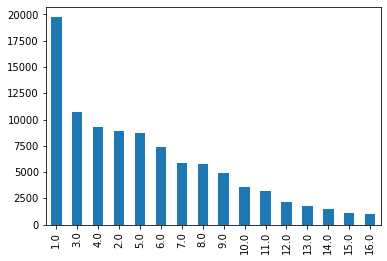

In [ ]:
df_final['max_M_entre_altas'].value_counts().plot(kind='bar')

Parece contraintuitivo que la mayoria de máximo_de_meses_entre_altas sea de solo 1 mes. Comprobamos algún pk_cid interesante.

In [ ]:
df_final[df_final['max_M_entre_altas'] == 1]

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency
2,16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0
26,22635,1.000000,2015-07,0.0,48,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,2.0
31,24763,0.750000,2015-05,0.0,66,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,2.0
44,29008,1.000000,2015-06,0.0,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,60.0,1,0,1.0,1.0,60.0,1.0,1.0,1.0,13.0
54,31624,1.000000,2015-08,1.0,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1,0,1.0,0.0,60.0,1.0,1.0,1.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
452151,1548196,0.500000,2016-09,0.0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,60.0,2,0,2.0,0.0,70.0,1.0,1.0,1.0,0.0
452152,1548197,0.500000,2016-09,0.5,40,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,60.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,10.0,1.0,0.0,40.0,1.0,0.0,60.0,3,0,3.0,0.0,110.0,1.0,1.0,1.0,0.0
452154,1548201,0.000000,2016-09,0.0,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,0.0
452155,1548202,0.500000,2016-09,0.0,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,0.0


In [ ]:
# este pk_cid tiene meses_recency =15 y el max_M_entre_altas de solo 1, lo que parece una combinación extraña.
# Al revisarlo vemos que se ha dado de alta en el segundo mes y después ha estado todo el resto de meses con el producto activo, así que es correcto.
df_[df_['pk_cid'] == 31624] 

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
237903,31624,2018-01-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,0,0,0,ES,41.0,H,51,N,186766.41,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241190,31624,2018-02-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.0,NaN
483768,31624,2018-03-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729027,31624,2018-04-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1222841,31624,2018-05-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474894,31624,2018-06-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479614,31624,2018-07-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168171,31624,2018-08-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171537,31624,2018-09-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943582,31624,2018-10-28,2017-11-26,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,0,1,0,0,ES,41.0,H,51,N,186766.41,0,2018,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

### Clientes sin altas (pero con productos?)

In [ ]:
df_final.isnull().sum()   #vemos que hay muchos clientes sin altas en todo el periodo, por eso los cálculos de fehcas salen NaN

pk_cid                             0
active_mean                        0
entry_date                         0
payroll                            0
age                                0
short_term_deposit_altas           0
short_term_deposit_bajas           0
short_term_deposit_revenue         0
loans_altas                        0
loans_bajas                        0
loans_revenue                      0
mortgage_altas                     0
mortgage_bajas                     0
mortgage_revenue                   0
funds_altas                        0
funds_bajas                        0
funds_revenue                      0
securities_altas                   0
securities_bajas                   0
securities_revenue                 0
long_term_deposit_altas            0
long_term_deposit_bajas            0
long_term_deposit_revenue          0
credit_card_altas                  0
credit_card_bajas                  0
credit_card_revenue                0
payroll_account_altas              0
p

Hay muchos nulos ya que son clientes sin altas. El problema es que hay clientes sin altas que sí tienen productos contratados durante todo el periodo, los 17 meses, que deberían tener un trato diferente a los clientes que solo se han dado de baja o que tienen 0 productos.

In [ ]:
# estos son los clientes que tienen todos los datos sin nulos == que tienen alguna alta durante el periodo. Son muy pocos respecto el total, solo un 21%...
df_final.shape[0] - df_final['mean_M_entre_altas'].isnull().sum(), round((df_final.shape[0] - df_final['mean_M_entre_altas'].isnull().sum()) / (df_final.shape[0])*100,  2)

(95438, 20.91)

In [ ]:
df_[df_['pk_cid'] == 17970] 
# este por ejemplo tiene 3 productos (payroll_account,	emc_account,	debit_card) con todo 1s, pero las nuevas columnas son NaN para clientes así.

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
237928,17970,2018-01-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
241167,17970,2018-02-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
586813,17970,2018-03-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
729000,17970,2018-04-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1222866,17970,2018-05-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474920,17970,2018-06-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,6,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479557,17970,2018-07-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,1.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,7,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168121,17970,2018-08-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171488,17970,2018-09-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943639,17970,2018-10-28,2015-04-16,KAT,1.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,1.0,1,1,1,0,0,ES,28.0,V,75,N,NaN,0,2018,10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df['pk_partition'].nunique()

17

Rellenar nulos con +17 o -1 por ejemplo? para que sea un valor límite

In [ ]:
# para ver pk_cids con altas Nulas
df_final[df_final['mean_M_entre_altas'].isnull()]

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency
0,15891,0.500000,2015-09,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,NaN,NaN,NaN,NaN
1,16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
5,17590,1.000000,2015-09,0.0,55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
6,17799,1.000000,2015-09,0.0,47,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
8,17980,1.000000,2015-09,0.0,78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.000000,2016-07,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456369,1553686,0.000000,2016-07,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456370,1553687,0.000000,2016-07,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456371,1553688,0.000000,2016-07,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# con el df limpiado vemos que es correcto que sea Nulos, pero si lo vemos con el df_ de productos originales (siguiente celda)
# tiene funds y long_term_deposit todos los meses
df[df['pk_cid'] == 17980]

,pk_cid,pk_partition,entry_date,active_customer,em_account_pp,payroll,em_account_p,age,em_account_p_previous_month,em_account_pp_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_diff,funds_diff,loans_diff,mortgage_diff,pension_plan_diff,payroll_account_diff,long_term_deposit_diff,debit_card_diff,credit_card_diff,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1222863,17980,2018-05-28,2018-05-04,1.0,0,0.0,0,77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474917,17980,2018-06-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479556,17980,2018-07-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168120,17980,2018-08-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171489,17980,2018-09-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943640,17980,2018-10-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962563,17980,2018-11-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628240,17980,2018-12-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4029235,17980,2019-01-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480632,17980,2019-02-28,2018-05-04,1.0,0,0.0,0,77,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df_[df_['pk_cid'] == 17980]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1222863,17980,2018-05-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1474917,17980,2018-06-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1479556,17980,2018-07-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168120,17980,2018-08-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2171489,17980,2018-09-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2943640,17980,2018-10-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2962563,17980,2018-11-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3628240,17980,2018-12-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2018,12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4029235,17980,2019-01-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2019,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4480632,17980,2019-02-28,2018-05-04,KFA,1.0,01 - TOP,0,0,0,1,0,1,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,V,77,N,282461.79,0,2019,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A continuación un ejemplo de cliente que tiene em_acount pero se da de baja. Si no los diferenciamos del cliente anterior, a nivel de las nuevas columnas serían identificados igual pero un tipo de clientes son muy fieles y los otros.

In [ ]:
df_[df_['pk_cid'] == 15891]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,28.0,H,59,N,NaN,0,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,59,N,NaN,0,2018,8,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Los que tienen NaNs puede ser:
- que **tienen productos contratados pero no han variado** (todo 1s) en los 17 periodos  (rellenar con 16 ya que son los periodos transcurridos reales de estudio)
- que **nunca han contratado** (rellenar con -1)
- que se han **dado de baja de algún/os productos que ya tenían de antes del primer partition y no lo volvieron a dar de alta ni en este ni en ningún otro** (estos sí están identificados pq las bajas están marcadas) (rellenar con -1)>


#### Sin altas, pero sí con bajas

In [ ]:
# Rellenamos los que tienen bajas y ninguna alta (nuevas columnas NaNs) --> con -1.

In [ ]:
df_final['mean_M_entre_altas'] = np.where((df_final['total_bajas'] > 0) & (df_final['mean_M_entre_altas'].isnull()) , -1, df_final['mean_M_entre_altas'])
df_final['min_M_entre_altas'] = np.where((df_final['total_bajas'] > 0) & (df_final['min_M_entre_altas'].isnull()) , -1, df_final['min_M_entre_altas'])
df_final['max_M_entre_altas'] = np.where((df_final['total_bajas'] > 0) & (df_final['max_M_entre_altas'].isnull()) , -1, df_final['max_M_entre_altas'])
df_final['meses_recency'] = np.where((df_final['total_bajas'] > 0) & (df_final['meses_recency'].isnull()) , -1, df_final['meses_recency'])

# df_final['mean_M_entre_altas'].fillna(-1, inplace=True)
# df_final['min_M_entre_altas'].fillna(-1, inplace=True)
# df_final['max_M_entre_altas'].fillna(-1, inplace=True)

In [ ]:
df_final

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency
0,15891,0.500000,2015-09,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0
1,16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
2,16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0
3,16502,0.888889,2015-09,0.0,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0
4,17457,1.000000,2015-09,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.000000,2016-07,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456369,1553686,0.000000,2016-07,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456370,1553687,0.000000,2016-07,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN
456371,1553688,0.000000,2016-07,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
df_final.isnull().sum()

pk_cid                             0
active_mean                        0
entry_date                         0
payroll                            0
age                                0
short_term_deposit_altas           0
short_term_deposit_bajas           0
short_term_deposit_revenue         0
loans_altas                        0
loans_bajas                        0
loans_revenue                      0
mortgage_altas                     0
mortgage_bajas                     0
mortgage_revenue                   0
funds_altas                        0
funds_bajas                        0
funds_revenue                      0
securities_altas                   0
securities_bajas                   0
securities_revenue                 0
long_term_deposit_altas            0
long_term_deposit_bajas            0
long_term_deposit_revenue          0
credit_card_altas                  0
credit_card_bajas                  0
credit_card_revenue                0
payroll_account_altas              0
p

#### Sin altas, pero con prod contratados (USO MEDIO)

- contador de cuántos productos ha probado un cliente. Sumar por columna y dividir entre el total de periodos que ha sido cliente, para saber productos que ya tiene y tal vez no han cambiado.
- o % de cuántos periodos ha estado con un producto activo respecto a todos los periodosxproductos (% retención en productos?)

##### PRODS 100% FIDELIDAD y Nº de pords diferentes PROBADOS

In [ ]:
# añadiendo em_account_pp y em_account_p ya que ahora no solo miramos diffs
prod_cols_2 = ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities', 'long_term_deposit','em_account_pp', 'credit_card', 'pension_plan', 'payroll_account', 'emc_account', 'debit_card','em_account_p', 'em_acount']
len(prod_cols_2)

14

In [ ]:
#calculamos sumatorio de 1s por producto y usuario. Tendremos que dividir por nº de periodos que el usuario es cliente para ver si ha estado todos los meses dado de alta
# (que sería un 1) o algún mes no tenía un 1 (<0)
df_prod_invisibles = df_.groupby(['pk_cid'])[prod_cols_2].sum()  #ojo ni tiene que ser entre 17, tiene que ser el nº de periodos del cliente especifico

In [ ]:
meses_estudio = df_.groupby(['pk_cid'])['pk_partition'].count()
meses_estudio = meses_estudio.to_frame().reset_index()
meses_estudio.columns = ['pk_cid', 'meses_usuario']
meses_estudio

,pk_cid,meses_usuario
0,15891,2
1,16063,7
2,16203,6
3,16502,9
4,17457,17
...,...,...
456368,1553685,1
456369,1553686,1
456370,1553687,1
456371,1553688,1


In [ ]:
df_prod_invisibles = pd.merge(df_prod_invisibles, meses_estudio, how='left', on='pk_cid')

In [ ]:
df_prod_invisibles

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,meses_usuario
0,15891,0,0,0,0,0,0,0,0,0.0,0,0,0,0,1,2
1,16063,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,7
2,16203,0,0,0,0,0,0,0,0,0.0,0,0,0,0,5,6
3,16502,0,0,0,0,0,0,0,0,0.0,0,5,0,0,8,9
4,17457,0,0,0,0,0,16,0,0,0.0,0,0,5,0,17,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1
456369,1553686,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1
456370,1553687,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1
456371,1553688,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,1


In [ ]:
# df_prod_invisibles_2 =  df_prod_invisibles.apply(lambda row : row / df_prod_invisibles['meses_usuario'], axis =1)
df_prod_invisibles[prod_cols_2] = df_prod_invisibles[prod_cols_2].div(df_prod_invisibles['meses_usuario'], axis=0) 

In [ ]:
df_prod_invisibles

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,meses_usuario
0,15891,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,2
1,16063,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,7
2,16203,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.833333,6
3,16502,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.555556,0.000000,0.0,0.888889,9
4,17457,0.0,0.0,0.0,0.0,0.0,0.941176,0.0,0.0,0.0,0.0,0.000000,0.294118,0.0,1.000000,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1
456369,1553686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1
456370,1553687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1
456371,1553688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1


In [ ]:
df_[df_['pk_cid'] == 15891]

,pk_cid,pk_partition,entry_date,entry_channel,active_customer,segment,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,country_id,region_code,gender,age,deceased,salary,deceased_num,year_partition,month_partition,em_account_p_previous_month,em_account_pp_previous_month,em_acount_previous_month,emc_account_previous_month,em_account_p_diff,em_acount_diff,emc_account_diff,short_term_deposit_previous_month,short_term_deposit_diff,funds_previous_month,funds_diff,loans_previous_month,loans_diff,mortgage_previous_month,mortgage_diff,pension_plan_previous_month,pension_plan_diff,payroll_account_previous_month,payroll_account_diff,long_term_deposit_previous_month,long_term_deposit_diff,debit_card_previous_month,debit_card_diff,credit_card_previous_month,credit_card_diff,securities_previous_month,securities_diff,em_acount_price,emc_account_price,payroll_account_price,funds_price,pension_plan_price,short_term_deposit_price,long_term_deposit_price,securities_price,loans_price,mortgage_price,debit_card_price,credit_card_price
1479563,15891,2018-07-28,2018-07-28,KAT,1.0,NaN,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1,ES,28.0,H,59,N,NaN,0,2018,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2168122,15891,2018-08-28,2018-07-28,KAT,0.0,02 - PARTICULARES,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,ES,28.0,H,59,N,NaN,0,2018,8,0.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Podemos calcular productos que el cliente ha probado (>0 & <=1) y éstos, cuántos ha estado todos los meses (==1) ya que los tiene todo el periodo de estudio

In [ ]:
to_create_2 = ['cuenta_prod_probados','cuenta_todo_1s',
             'ahorro_prod_probados','ahorro_todo_1s',
             'financiacion_prod_probados','financiacion_todo_1s',
             'n_prod_probados','prods_todo_1s']

#añadimos em_account_pp y em_account_p
buckets_2 =   {'cuenta' : ['em_acount', 'emc_account','em_account_pp','em_account_p', 'payroll_account'],
             'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
             'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}
    
for col in to_create_2:
    df_prod_invisibles[col] = 0

for grupo in buckets_2:
  for producto in buckets_2[grupo]:
      df_prod_invisibles[grupo + '_prod_probados'] += np.where((df_prod_invisibles[producto] > 0) & (df_prod_invisibles[producto] <= 1), 1, 0)
      df_prod_invisibles[grupo + '_todo_1s'] += np.where((df_prod_invisibles[producto] == 1), 1, 0)

        
df_prod_invisibles['n_prod_probados'] = df_prod_invisibles['cuenta_prod_probados'] + df_prod_invisibles['ahorro_prod_probados'] + df_prod_invisibles['financiacion_prod_probados']
df_prod_invisibles['prods_todo_1s'] = df_prod_invisibles['cuenta_todo_1s'] + df_prod_invisibles['ahorro_todo_1s'] + df_prod_invisibles['financiacion_todo_1s']

In [ ]:
df_prod_invisibles

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s
0,15891,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,2,1,0,0,0,0,0,1,0
1,16063,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,7,0,0,0,0,0,0,0,0
2,16203,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.833333,6,1,0,0,0,0,0,1,0
3,16502,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.555556,0.000000,0.0,0.888889,9,2,0,0,0,0,0,2,0
4,17457,0.0,0.0,0.0,0.0,0.0,0.941176,0.0,0.0,0.0,0.0,0.000000,0.294118,0.0,1.000000,17,1,1,1,0,1,0,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0
456369,1553686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0
456370,1553687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0
456371,1553688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0


##### USO MEDIO

Ya que tenemos el tiempo medio de cada cliente en cada producto, crearemos variables de uso medio también

In [ ]:
a = df_prod_invisibles[['pk_cid','em_acount', 'emc_account','em_account_pp','em_account_p', 'payroll_account']]
a = a.replace(0, np.NaN)
a['medias'] = a[['em_acount', 'emc_account','em_account_pp','em_account_p', 'payroll_account']].mean(axis=1, skipna=True)
a

# dilema de si tener en cuenta los 0 para la media o no, finalmente no los tenemos en cuenta, por eso el skipna=True

In [ ]:
# #añadimos em_account_pp y em_account_p
# buckets_2 =   {'cuenta' : ['em_acount', 'emc_account','em_account_pp','em_account_p', 'payroll_account'],
#              'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
#              'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}

df_nuls_uso_medio = df_prod_invisibles.replace(0, np.NaN)

for grupo in buckets_2:
      df_prod_invisibles[grupo + '_uso_medio'] = df_nuls_uso_medio[buckets_2[grupo]].mean(axis=1, skipna=True)


In [ ]:
df_prod_invisibles.fillna(0, inplace=True)

In [ ]:
df_prod_invisibles

,pk_cid,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,15891,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.500000,2,1,0,0,0,0,0,1,0,0.500000,0.000000,0.000000
1,16063,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,7,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,16203,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.833333,6,1,0,0,0,0,0,1,0,0.833333,0.000000,0.000000
3,16502,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.555556,0.000000,0.0,0.888889,9,2,0,0,0,0,0,2,0,0.722222,0.000000,0.000000
4,17457,0.0,0.0,0.0,0.0,0.0,0.941176,0.0,0.0,0.0,0.0,0.000000,0.294118,0.0,1.000000,17,1,1,1,0,1,0,3,1,1.000000,0.941176,0.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456369,1553686,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456370,1553687,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456371,1553688,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000


In [ ]:
for pr in prod_cols_2:
  df_prod_invisibles.drop(pr, axis=1, inplace=True)

In [ ]:
df_final = pd.merge(df_final, df_prod_invisibles,  how='left', on='pk_cid')

Ahora faltaría rellenar los nulos de df_final restantes. 
Los que tienen NaNs puede ser:

- que tienen productos contratados pero no han variado (todo 1s) en los 17 periodos (rellenar con 16)

- que nunca han contratado (rellenar con -1??)

- *que se han dado de baja de algún/os productos que ya tenían de antes del primer partition y no lo volvieron a dar de alta ni en este ni en ningún otro (estos sí están identificados pq las bajas están marcadas) (rellenar con -1)* **DONE**


In [ ]:
df_final.isnull().sum().sort_values(ascending=False)

min_M_entre_altas            345485
max_M_entre_altas            345485
mean_M_entre_altas           345485
meses_recency                345485
pk_cid                            0
                              ...  
credit_card_altas                 0
long_term_deposit_revenue         0
long_term_deposit_bajas           0
long_term_deposit_altas           0
financiacion_uso_medio            0
Length: 71, dtype: int64

que tienen productos contratados pero no han variado (todo 1s) en los 17 periodos (rellenar con 16)

In [ ]:
df_final['mean_M_entre_altas'] = np.where((df_final['prods_todo_1s'] > 0) & (df_final['mean_M_entre_altas'].isnull()) , 16, df_final['mean_M_entre_altas'])
df_final['min_M_entre_altas'] = np.where((df_final['prods_todo_1s'] > 0) & (df_final['min_M_entre_altas'].isnull()) , 16, df_final['min_M_entre_altas'])
df_final['max_M_entre_altas'] = np.where((df_final['prods_todo_1s'] > 0) & (df_final['max_M_entre_altas'].isnull()) , 16, df_final['max_M_entre_altas'])
df_final['meses_recency'] = np.where((df_final['prods_todo_1s'] > 0) & (df_final['meses_recency'].isnull()) , 16, df_final['meses_recency'])

In [ ]:
df_final.isnull().sum().sort_values(ascending=False)

min_M_entre_altas            105989
max_M_entre_altas            105989
mean_M_entre_altas           105989
meses_recency                105989
pk_cid                            0
                              ...  
credit_card_altas                 0
long_term_deposit_revenue         0
long_term_deposit_bajas           0
long_term_deposit_altas           0
financiacion_uso_medio            0
Length: 71, dtype: int64

que nunca han contratado (rellenar con -1)

In [ ]:
df_final['mean_M_entre_altas'] = np.where((df_final['n_prod_probados'] == 0) & (df_final['mean_M_entre_altas'].isnull()) , -1, df_final['mean_M_entre_altas'])
df_final['min_M_entre_altas'] = np.where((df_final['n_prod_probados'] == 0) & (df_final['min_M_entre_altas'].isnull()) , -1, df_final['min_M_entre_altas'])
df_final['max_M_entre_altas'] = np.where((df_final['n_prod_probados'] == 0) & (df_final['max_M_entre_altas'].isnull()) , -1, df_final['max_M_entre_altas'])
df_final['meses_recency'] = np.where((df_final['n_prod_probados'] == 0) & (df_final['meses_recency'].isnull()) , -1, df_final['meses_recency'])

In [ ]:
df_final.isnull().sum().sort_values(ascending=False)

pk_cid                       0
ahorro_bajas                 0
max_recurrencia              0
n_prods_con_altas            0
financiacion_revenue         0
                            ..
credit_card_altas            0
long_term_deposit_revenue    0
long_term_deposit_bajas      0
long_term_deposit_altas      0
financiacion_uso_medio       0
Length: 71, dtype: int64

In [ ]:
df_final

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,15891,0.500000,2015-09,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,2,1,0,0,0,0,0,1,0,0.500000,0.000000,0.000000
1,16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,7,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0,6,1,0,0,0,0,0,1,0,0.833333,0.000000,0.000000
3,16502,0.888889,2015-09,0.0,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0,9,2,0,0,0,0,0,2,0,0.722222,0.000000,0.000000
4,17457,1.000000,2015-09,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0,17,1,1,1,0,1,0,3,1,1.000000,0.941176,0.294118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
456368,1553685,0.000000,2016-07,0.0,52,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456369,1553686,0.000000,2016-07,0.0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456370,1553687,0.000000,2016-07,0.0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
456371,1553688,0.000000,2016-07,0.0,43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
df_final.to_pickle("/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/df_grande_clusters.pkl")

In [ ]:
# import pickle

# ruta_marc = '/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/'

# with open(ruta_marc+'df_grande_clusters.pkl', 'rb') as handle:
#     df_final = pickle.load(handle)

# Modelo

In [ ]:
df_final.head(5)

,pk_cid,active_mean,entry_date,payroll,age,short_term_deposit_altas,short_term_deposit_bajas,short_term_deposit_revenue,loans_altas,loans_bajas,loans_revenue,mortgage_altas,mortgage_bajas,mortgage_revenue,funds_altas,funds_bajas,funds_revenue,securities_altas,securities_bajas,securities_revenue,long_term_deposit_altas,long_term_deposit_bajas,long_term_deposit_revenue,credit_card_altas,credit_card_bajas,credit_card_revenue,payroll_account_altas,payroll_account_bajas,payroll_account_revenue,emc_account_altas,emc_account_bajas,emc_account_revenue,debit_card_altas,debit_card_bajas,debit_card_revenue,em_acount_altas,em_acount_bajas,em_acount_revenue,pension_plan_altas,pension_plan_bajas,pension_plan_revenue,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,15891,0.500000,2015-09,0.0,59,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,2,1,0,0,0,0,0,1,0,0.500000,0.000000,0.000000
1,16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,7,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,16203,0.833333,2015-09,0.0,70,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0,6,1,0,0,0,0,0,1,0,0.833333,0.000000,0.000000
3,16502,0.888889,2015-09,0.0,58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0,9,2,0,0,0,0,0,2,0,0.722222,0.000000,0.000000
4,17457,1.000000,2015-09,0.0,54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,4.0,300.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0,17,1,1,1,0,1,0,3,1,1.000000,0.941176,0.294118


In [ ]:
# buckets =   {'cuenta' : ['em_acount', 'emc_account', 'payroll_account'],
#              'ahorro':  ['funds', 'pension_plan', 'short_term_deposit', 'long_term_deposit', 'securities'],
#              'financiacion': ['loans', 'mortgage', 'debit_card', 'credit_card']}

In [ ]:
for grupo in buckets:
  for producto in buckets[grupo]:
      df_final.drop(producto + '_altas', axis=1, inplace= True)
      df_final.drop(producto + '_bajas', axis=1, inplace= True)
      df_final.drop(producto + '_revenue', axis=1, inplace= True)


In [ ]:
df_final.head(5)

,pk_cid,active_mean,entry_date,payroll,age,cuenta_altas,cuenta_bajas,cuenta_revenue,ahorro_altas,ahorro_bajas,ahorro_revenue,financiacion_altas,financiacion_bajas,financiacion_revenue,n_prods_con_altas,max_recurrencia,total_altas,total_bajas,total_revenue,min_M_entre_altas,max_M_entre_altas,mean_M_entre_altas,meses_recency,meses_usuario,cuenta_prod_probados,cuenta_todo_1s,ahorro_prod_probados,ahorro_todo_1s,financiacion_prod_probados,financiacion_todo_1s,n_prod_probados,prods_todo_1s,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
0,15891,0.500000,2015-09,0.0,59,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,1.0,0.0,-1.0,-1.0,-1.0,-1.0,2,1,0,0,0,0,0,1,0,0.500000,0.000000,0.000000
1,16063,0.714286,2015-09,0.0,62,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,7,0,0,0,0,0,0,0,0,0.000000,0.000000,0.000000
2,16203,0.833333,2015-09,0.0,70,1.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,1.0,0.0,10.0,1.0,1.0,1.0,4.0,6,1,0,0,0,0,0,1,0,0.833333,0.000000,0.000000
3,16502,0.888889,2015-09,0.0,58,2.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,2.0,0.0,20.0,1.0,3.0,2.0,4.0,9,2,0,0,0,0,0,2,0,0.722222,0.000000,0.000000
4,17457,1.000000,2015-09,0.0,54,0.0,0.0,0.0,1.0,1.0,40.0,5.0,4.0,300.0,2,0,6.0,5.0,340.0,2.0,8.0,3.2,0.0,17,1,1,1,0,1,0,3,1,1.000000,0.941176,0.294118


In [ ]:
df_final.shape

(456373, 35)

Se usan estas características para realizar la segmentación de clientes y que sea facil entender las fichas de clientes que se crearán.

In [ ]:
to_model = ['pk_cid','age','meses_recency','mean_M_entre_altas', 'total_revenue','prods_todo_1s','active_mean',
            'n_prod_probados','total_altas', 'cuenta_uso_medio','ahorro_uso_medio', 'financiacion_uso_medio']

df_final = df_final[to_model]

In [ ]:
df_final = df_final.set_index('pk_cid')

In [ ]:
df_final.shape

(456373, 11)

In [ ]:
df_final.describe()

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
count,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000,456373.000000
mean,30.605036,9.179299,9.003495,16.731730,0.687893,0.383969,1.118583,0.452255,0.701420,0.050427,0.083889
std,12.322632,7.686697,7.717437,47.679564,0.604271,0.462915,1.009791,1.125817,0.424131,0.184530,0.240084
min,2.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,-1.000000,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.250000,0.000000,0.000000
50%,25.000000,16.000000,16.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,36.000000,16.000000,16.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000
max,105.000000,16.000000,16.000000,720.000000,7.000000,1.000000,9.000000,16.000000,1.000000,1.000000,1.000000


In [ ]:
df_final

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
pk_cid,,,,,,,,,,,
15891,59,-1.0,-1.0,0.0,0,0.500000,1,0.0,0.500000,0.000000,0.000000
16063,62,-1.0,-1.0,0.0,0,0.714286,0,0.0,0.000000,0.000000,0.000000
16203,70,4.0,1.0,10.0,0,0.833333,1,1.0,0.833333,0.000000,0.000000
16502,58,4.0,2.0,20.0,0,0.888889,2,2.0,0.722222,0.000000,0.000000
17457,54,0.0,3.2,340.0,1,1.000000,3,6.0,1.000000,0.941176,0.294118
...,...,...,...,...,...,...,...,...,...,...,...
1553685,52,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553686,30,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553687,21,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000


In [ ]:
df_final = df_final.astype(int)

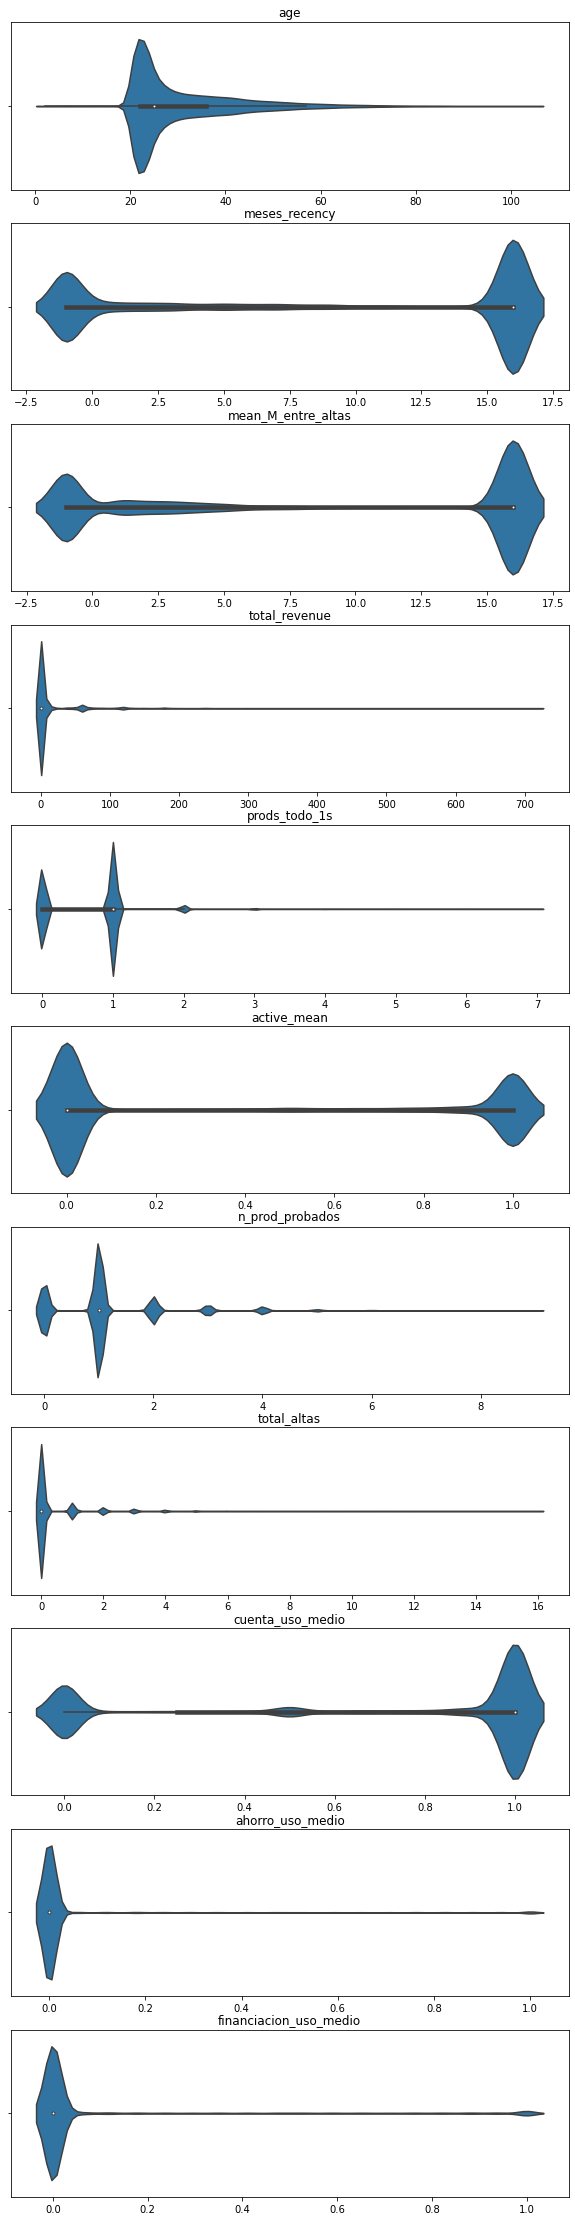

In [ ]:
fig, ax = plt.subplots( len(df_final.columns), 1, figsize=(10,40) )
for col, i in zip(df_final.columns, range(len(df_final.columns))):
    sns.violinplot(ax = ax[i], x=df_final[col])
    ax[i].set_title(col)
    ax[i].xaxis.label.set_visible(False)
    
plt.show()

Vemos que hay muchos usuarios con age < 18 así que os consideramos como outliers y los sacamos. Consideramos que son usuarios no TARGET ya que son cuentas controladas por sus padres/familiares.

In [ ]:
df_final[df_final['age'] >= 18]

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
pk_cid,,,,,,,,,,,
15891,59,-1.0,-1.0,0.0,0,0.500000,1,0.0,0.500000,0.000000,0.000000
16063,62,-1.0,-1.0,0.0,0,0.714286,0,0.0,0.000000,0.000000,0.000000
16203,70,4.0,1.0,10.0,0,0.833333,1,1.0,0.833333,0.000000,0.000000
16502,58,4.0,2.0,20.0,0,0.888889,2,2.0,0.722222,0.000000,0.000000
17457,54,0.0,3.2,340.0,1,1.000000,3,6.0,1.000000,0.941176,0.294118
...,...,...,...,...,...,...,...,...,...,...,...
1553685,52,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553686,30,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553687,21,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000


In [ ]:
np.quantile(df_final['age'], q=0.006)

18.0

In [ ]:
df_final[df_final['age'] >= np.quantile(df_final['age'], q=0.006)]

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio
pk_cid,,,,,,,,,,,
15891,59,-1.0,-1.0,0.0,0,0.500000,1,0.0,0.500000,0.000000,0.000000
16063,62,-1.0,-1.0,0.0,0,0.714286,0,0.0,0.000000,0.000000,0.000000
16203,70,4.0,1.0,10.0,0,0.833333,1,1.0,0.833333,0.000000,0.000000
16502,58,4.0,2.0,20.0,0,0.888889,2,2.0,0.722222,0.000000,0.000000
17457,54,0.0,3.2,340.0,1,1.000000,3,6.0,1.000000,0.941176,0.294118
...,...,...,...,...,...,...,...,...,...,...,...
1553685,52,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553686,30,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000
1553687,21,-1.0,-1.0,0.0,0,0.000000,0,0.0,0.000000,0.000000,0.000000


Llegamos a este punto tenemos todo listo para construir nuestro pipeline.

Los pasos que va a realizar son:

1. Filtramos los outliers con nuestro propio ***Transformer***. **POR TANTO VAMOS NUESTRO DATAFRAME DE SALIDA SERÁ MÁS PEQUEÑO.**

2. Estandarizamos los valores, usando ***MinMaxScaler***.

6. Hacemos un fit con KMeans para calcular la **inertia** de los grupos (la dispersión de los datos al centroide).

Técnica del ***Elbow Curve***: todo esto lo hacemos en una loop porque queremos ver cuando hay un cambio brusco en la inertia y por tanto, **aumentar más el número de centroides no nos sale a cuenta porque la ganacia marginal es muy pequeña.**

In [ ]:
class OutlierFilter(BaseEstimator, TransformerMixin):
    '''
    Clase que filtra los outliers utilizando np.quantile()
    Los cuantiles a filtrar así como las columnas a filtrar son los parámetros de la clase.
    '''
    
    def __init__(self, q, col_to_filter):
        self.q = q
        self.col_to_filter = col_to_filter
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y = None):
        '''
        El método considera outlier a aquel cliente que es outlier en todas las columnas que le pasas.
        Es decir: si tiene que filtrar importe y número de pedidos, sólo va a eliminar aquellos clientes
        que son outlier tanto en importe como número de pedidos. Si eres outlier en importe pero no en pedido
        no se te va a filtrar del dataset.
        '''
        
        # lista vacía
        criteria_list = []
        
        # agregamos a la lista los clientes que son outliers
        for col in self.col_to_filter:
            criteria = X[col] >= np.quantile(X[col], q = self.q)
            criteria_list.append(criteria)
            
        # si hay más de 1 columna
        if len(self.col_to_filter) > 1:
            
            # creamos el criterio global: es decir outlier en todas las columnas
            global_criteria = criteria_list[0]
            
            for criteria in criteria_list[1:]:
                global_criteria = global_criteria & criteria  #solo quedarán como TRUE los TRUE+TRUE por index
                
        else:
            global_criteria = criteria_list[0]
            
        # filtramos nuestra dataframe
        X = X[global_criteria]
        
        # guardamos el índice como parámetro de la clase porque en caso contrario lo perderíamos.
        self.index = X.index
        
        return X

In [ ]:
X = df_final.copy(deep=True)
columns = list(X.columns)
index = list(X.index)
len(X.columns.to_list())

11

In [ ]:
pipe = Pipeline(steps = [
    ("OutlierFilter", OutlierFilter(q = 0.006, col_to_filter = ["age"])),
    ('MinMaxScaler', MinMaxScaler())
])

In [ ]:
df_outlier_scaled = pipe.fit_transform(X)

In [ ]:
df_outlier_scaled.shape

(453667, 11)

## Elbow Curve

In [ ]:
CALCULATE_ELBOW = True

In [ ]:
if CALCULATE_ELBOW:
    st = time.time()

    sse = {}

    for k in range(3, 12):

        print(f"Fitting pipe with {k} clusters")

        clustering_model = KMeans(n_clusters = k, random_state=42)

        clustering_model.fit(df_outlier_scaled)

        sse[k] = clustering_model.inertia_        #VIP. Inertia = DIstancia de cada uno de los puntos al centroide. 
                                                  #guarda para cada k su valor de inertia

    et = time.time()
    print("Elbow curve took {} minutes.".format(round((et - st)/60), 2))

Fitting pipe with 3 clusters
Fitting pipe with 4 clusters
Fitting pipe with 5 clusters
Fitting pipe with 6 clusters
Fitting pipe with 7 clusters
Fitting pipe with 8 clusters
Fitting pipe with 9 clusters
Fitting pipe with 10 clusters
Fitting pipe with 11 clusters
Elbow curve took 1 minutes.


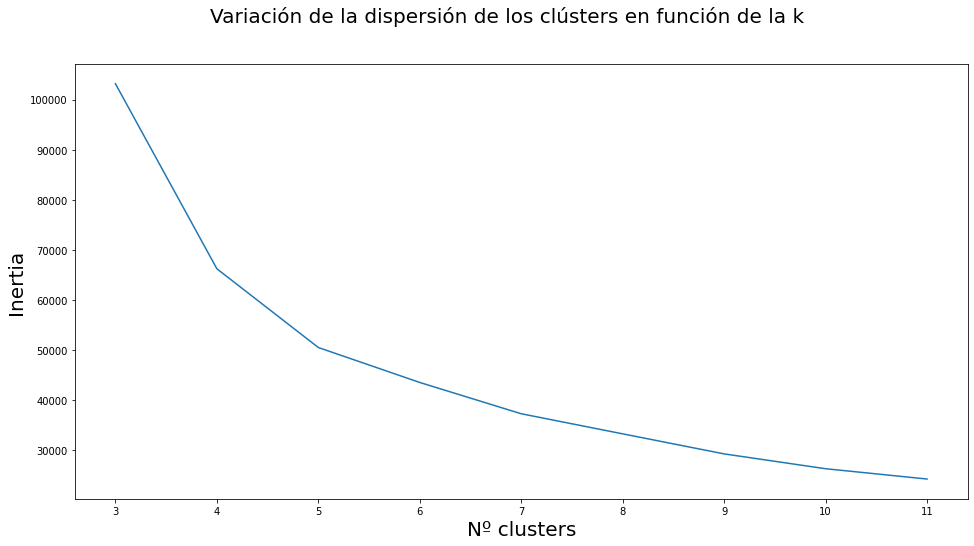

In [ ]:
if CALCULATE_ELBOW:
    fig = plt.figure(figsize = (16, 8))
    ax = fig.add_subplot()

    x_values = list(sse.keys())
    y_values = list(sse.values())

    ax.plot(x_values, y_values, label = "Inertia/dispersión de los clústers")
    plt.xlabel('Nº clusters',fontsize = 20)
    plt.ylabel('Inertia',fontsize = 20)
    fig.suptitle("Variación de la dispersión de los clústers en función de la k", fontsize = 20);

https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb

In [ ]:
# from sklearn.metrics import silhouette_score

# sil = []
# kmax = 9

# # dissimilarity would not be defined for a single cluster, thus, minimum number of clusters should be 2
# for k in range(3, kmax):
#   kmeans = KMeans(n_clusters = k).fit(df_scaled)
#   labels = kmeans.labels_
#   sil.append(silhouette_score(df_scaled, labels, metric = 'euclidean'))


In [ ]:
# # Instantiate the KMeans models
# #
# km = KMeans(n_clusters=4, random_state=42)
# #
# # Fit the KMeans model
# #
# km.fit_predict(df_scaled)
# #
# # Calculate Silhoutte Score
# #
# score = silhouette_score(df_scaled, km.labels_, metric='euclidean')
# #
# # Print the score
# #
# print('Silhouetter Score: %.3f' % score)

## Segmentación clientes con K adecuada

Ahora que hemos determinado el número de centroides correcto podemos fittear nuestro pipeline con la ***k adecuada.***

Dado que vamos a realizar nuestra segmentación con KMeans y vamos a suministrarle las variables de nuestro interés, a veces, a KMeans se le conoce como **segmentación no supervisada pero guiada***. Guiada porque de alguna manera el data scientist le dice (lo guía) a que discrimine usando unas variables y no otras.

Pruebo con 5

In [ ]:
pipe = Pipeline(steps = [
    ("OutlierFilter", OutlierFilter(q = 0.006, col_to_filter = ["age"])),
    ('MinMaxScaler', MinMaxScaler()),
    ("Clustering", KMeans(n_clusters = 5, random_state=42))
])

In [ ]:
df_final.shape

(456373, 11)

In [ ]:
pipe.fit(df_final) #fit con todos los pasos, par que los outliers no afecten a donde ponemos los centroides

Pipeline(steps=[('OutlierFilter',
                 OutlierFilter(col_to_filter=['age'], q=0.006)),
                ('MinMaxScaler', MinMaxScaler()),
                ('Clustering', KMeans(n_clusters=5, random_state=42))])

In [ ]:
pipe[1]

MinMaxScaler()

cuando vamos a hacer el predict (asignar a cada cliente su centroide), estandarizar pero **no filtrar los outliers** (todos los clientes tienen que tener un grupo). Si hacemos el predict con todo el pipeline, algunos clientes no se van a asignar a ningún grupo.

In [ ]:
# creamos un dataframe escalado con el transform solo del 2, para evitar el paso de OutlierFilter

X_scaled = pipe[1].transform(df_final)  #transform sense fer el pas dels outliers, pq també volem assignar-los a algun dels clusters trobats al fit

X_scaled.shape

(456373, 11)

In [ ]:
# hacemos el predict, en este caso tendremos para cada cliente su centroide/clúster.
labels = pipe["Clustering"].predict(X_scaled)

In [ ]:
labels

array([1, 1, 1, ..., 1, 1, 1], dtype=int32)

In [ ]:
X['cluster'] = labels
X['cluster'] += 1
X['cluster'].value_counts()

1    165840
2    149015
3     76284
4     33681
5     31553
Name: cluster, dtype: int64

In [ ]:
df_final.columns

Index(['age', 'meses_recency', 'mean_M_entre_altas', 'total_revenue',
       'prods_todo_1s', 'active_mean', 'n_prod_probados', 'total_altas',
       'cuenta_uso_medio', 'ahorro_uso_medio', 'financiacion_uso_medio'],
      dtype='object')

## Fichas de los clientes

El último paso, usa vez que tenemos hecha nuestra segmentación completa es crear una ***ficha resumen*** de cada grupo con las principales variables utilizadas.

In [ ]:
ficha_df = pd.DataFrame()
ficha_df

""


In [ ]:
for i, col in enumerate(['age','meses_recency','mean_M_entre_altas', 'total_revenue','prods_todo_1s','active_mean',
                        'n_prod_probados','total_altas', 'cuenta_uso_medio','ahorro_uso_medio', 'financiacion_uso_medio']):
  
    resumen_data = X[["cluster", col]].groupby("cluster").describe().T.iloc[[1,2,3,-1]]
    ficha_df = ficha_df.append(resumen_data)

In [ ]:
# X[["cluster", 'age']].groupby("cluster").describe().T.iloc[[1,2,3,-1]]

In [ ]:
pd.set_option('max_rows', 500)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [ ]:
# caract_cliente = 'age', 
# Recency ='meses_recency'
# Frequency =  'mean_M_entre_altas'
# Monetary = 'total_revenue'
# Fidelización = 'prods_todo_1s'
# actividad = 'active_mean',
#             'n_prod_probados',
#             'total_altas', 
#             'cuenta_uso_medio',
#             'ahorro_uso_medio', 
#             'financiacion_uso_medio'

In [ ]:
# generamos nuestro multiindex
out_index = [
    "Caract_cliente",
    "Recency",
    "Frequency",
    "Monetary",
    "Fidelización",
    "Actividad",
    "Actividad",
    "Actividad",
    "Actividad",
    "Actividad",
    "Actividad",
]

inner_index = [ 
    "age",
    "Meses última compra",
    "Nº meses entre alta de media",
    "Pagos clientes",
    "Nº prods 100% fiel",
    'Actividad en app de media',
    'Nº prods probados',
    'Total altas', 
    'Uso medio Cuentas',
    'Uso medio prods Ahorro', 
    'Uso medio prods Financiación'
]

estadisticos = ["Media", "Desviación", "Mínimo", "Máximo"]

new_multi_index = []

for oi, ii, in zip(out_index, inner_index):
    for es in estadisticos:
        new_multi_index.append((oi, ii, es))
        
new_multi_index

[('Caract_cliente', 'age', 'Media'),
 ('Caract_cliente', 'age', 'Desviación'),
 ('Caract_cliente', 'age', 'Mínimo'),
 ('Caract_cliente', 'age', 'Máximo'),
 ('Recency', 'Meses última compra', 'Media'),
 ('Recency', 'Meses última compra', 'Desviación'),
 ('Recency', 'Meses última compra', 'Mínimo'),
 ('Recency', 'Meses última compra', 'Máximo'),
 ('Frequency', 'Nº meses entre alta de media', 'Media'),
 ('Frequency', 'Nº meses entre alta de media', 'Desviación'),
 ('Frequency', 'Nº meses entre alta de media', 'Mínimo'),
 ('Frequency', 'Nº meses entre alta de media', 'Máximo'),
 ('Monetary', 'Pagos clientes', 'Media'),
 ('Monetary', 'Pagos clientes', 'Desviación'),
 ('Monetary', 'Pagos clientes', 'Mínimo'),
 ('Monetary', 'Pagos clientes', 'Máximo'),
 ('Fidelización', 'Nº prods 100% fiel', 'Media'),
 ('Fidelización', 'Nº prods 100% fiel', 'Desviación'),
 ('Fidelización', 'Nº prods 100% fiel', 'Mínimo'),
 ('Fidelización', 'Nº prods 100% fiel', 'Máximo'),
 ('Actividad', 'Actividad en app de m

In [ ]:
def generate_multiindex(list_of_tuples, names):
    return pd.MultiIndex.from_tuples(list_of_tuples, names = names)

In [ ]:
names = ["Grupo Indicadores", "Indicador", "Estadístico"]
index_ficha = generate_multiindex(new_multi_index, names)
ficha_df.set_index(index_ficha, inplace = True)

In [ ]:
index_ficha

MultiIndex([('Caract_cliente',                          'age',      'Media'),
            ('Caract_cliente',                          'age', 'Desviación'),
            ('Caract_cliente',                          'age',     'Mínimo'),
            ('Caract_cliente',                          'age',     'Máximo'),
            (       'Recency',          'Meses última compra',      'Media'),
            (       'Recency',          'Meses última compra', 'Desviación'),
            (       'Recency',          'Meses última compra',     'Mínimo'),
            (       'Recency',          'Meses última compra',     'Máximo'),
            (     'Frequency', 'Nº meses entre alta de media',      'Media'),
            (     'Frequency', 'Nº meses entre alta de media', 'Desviación'),
            (     'Frequency', 'Nº meses entre alta de media',     'Mínimo'),
            (     'Frequency', 'Nº meses entre alta de media',     'Máximo'),
            (      'Monetary',               'Pagos clientes',  

In [ ]:
tamaño_clusters = X.groupby("cluster").size().to_frame().T
tamaño_clusters.set_index(generate_multiindex([("General", "Clúster", "Tamaño")] , names), inplace = True)

In [ ]:
ficha_df = tamaño_clusters.append(ficha_df)

In [ ]:
ficha_df.style.background_gradient(cmap = 'Blues', axis = 1)

In [ ]:
X

,age,meses_recency,mean_M_entre_altas,total_revenue,prods_todo_1s,active_mean,n_prod_probados,total_altas,cuenta_uso_medio,ahorro_uso_medio,financiacion_uso_medio,cluster
pk_cid,,,,,,,,,,,,
15891,59,-1,-1,0,0,0,1,0,0,0,0,2
16063,62,-1,-1,0,0,0,0,0,0,0,0,2
16203,70,4,1,10,0,0,1,1,0,0,0,2
16502,58,4,2,20,0,0,2,2,0,0,0,2
17457,54,0,3,340,1,1,3,6,1,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1553685,52,-1,-1,0,0,0,0,0,0,0,0,2
1553686,30,-1,-1,0,0,0,0,0,0,0,0,2
1553687,21,-1,-1,0,0,0,0,0,0,0,0,2


In [ ]:
# X.to_pickle("/content/drive/MyDrive/DATA SCIENCE/Nuclio DS/Capstone NDS/Dataset/Pickle_clusters.pkl")

# Conclusión


Los algoritmos no supervisados son herramientas **muy potentes** que cualquier data scientist debe tener a mano. Saber el funcionamiento y hacer la correcta implementación de estos, puede permitir **extraer información muy valiosa y tomar mejores decisiones de negocio**. Hemos visto diferentes algoritmos y técnicas no supervisadas (***KMeans y modelo RFM***) que nos permiten crear **grupos homogéneos y accionables** de clientes y así mejorar los indicadores de la compañia.

Además de esto, hemos aprendido a utilizar los pipelines de sklearn para **automatizar al máximo el tratamiento de datos** así como implementar nuestros propios ***Transformers*** que puede ser utilizados dentro del pipeline.

En el documento de **Cluster Naming** se identifican los diferentes grupos según características y se les asignan nombres más marketinianos para facilitar su targetización.